In [ ]:
# 1단계 이미지 로드 및 리사이징

원본 이미지 크기:
ballet.jpg: (460, 260)
lake.jpg: (1527, 850)
ltt.jpg: (570, 299)

리사이징 후 이미지 크기:
ballet.jpg: (460, 260)
lake.jpg: (460, 260)
ltt.jpg: (460, 260)


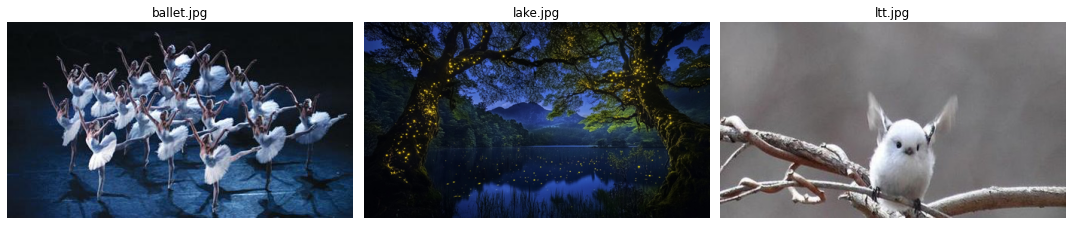

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 현재 작업 디렉토리의 이미지 파일 경로 설정
image_files = ['ballet.jpg', 'lake.jpg', 'ltt.jpg']

# 이미지 읽기
images = [Image.open(file) for file in image_files]

# 원본 이미지 크기 출력
print("원본 이미지 크기:")
for file, img in zip(image_files, images):
    print(f"{file}: {img.size}")

# 가장 작은 크기 찾기
min_width = min(img.size[0] for img in images)
min_height = min(img.size[1] for img in images)

# 이미지 리사이징
resized_images = [img.resize((min_width, min_height), Image.LANCZOS) for img in images]

# 리사이징된 이미지 크기 출력
print("\n리사이징 후 이미지 크기:")
for file, img in zip(image_files, resized_images):
    print(f"{file}: {img.size}")

# 리사이징된 이미지 시각화
plt.figure(figsize=(15, 5))
for i, (file, img) in enumerate(zip(image_files, resized_images), 1):
    plt.subplot(1, 3, i)
    plt.imshow(np.array(img))
    plt.title(file)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 리사이징된 이미지 저장
for file, img in zip(image_files, resized_images):
    img.save(f'resized_{file}')


In [ ]:
# 2단계 모델 로드 및 라벨 정의

In [2]:
import os
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# PixelLib 모델 다운로드 및 로드
model_dir = './'  # 모델 파일을 저장할 디렉토리 (현재 디렉토리)
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# 모델이 없으면 다운로드
if not os.path.exists(model_file):
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
    print("Downloading model...")
    import urllib.request
    urllib.request.urlretrieve(model_url, model_file)
    print("Model downloaded!")

# PixelLib 세그멘테이션 모델 로드
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 리사이징된 이미지 파일 불러오기
resized_files = ['resized_ballet.jpg', 'resized_lake.jpg', 'resized_ltt.jpg']

# PASCAL VOC 데이터셋 라벨 정의
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]



Model downloaded!


In [ ]:
# 2-2단계: 라벨링된 이미지에 오파시티 적용

Processing resized_ballet.jpg for opacity adjustment...


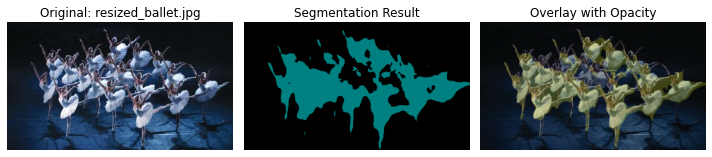

Processing resized_lake.jpg for opacity adjustment...


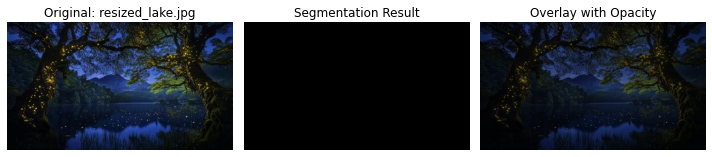

Processing resized_ltt.jpg for opacity adjustment...


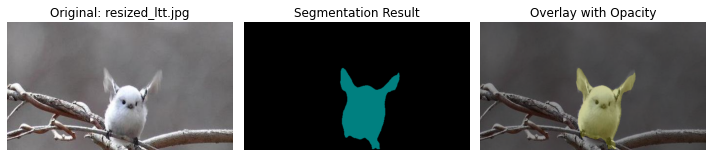

In [5]:
# 오파시티를 적용한 라벨링 시각화
for file in resized_files:
    print(f"Processing {file} for opacity adjustment...")
    
    # 이미지 읽기
    img = cv2.imread(file)
    
    # 세그멘테이션 수행
    segvalues, output = model.segmentAsPascalvoc(file)
    
    # 오파시티 설정 (0.0: 완전히 투명, 1.0: 완전히 불투명)
    opacity = 0.4
    
    # 세그멘테이션 결과와 원본 이미지를 합성
    output_resized = cv2.resize(output, (img.shape[1], img.shape[0]))  # 원본 크기로 리사이즈
    overlay = cv2.addWeighted(img, 1 - opacity, output_resized, opacity, 0)
    
    # 결과 시각화
    plt.figure(figsize=(10, 5))
    
    # 원본 이미지 표시
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original: {file}")
    plt.axis('off')
    
    # 세그멘테이션 결과 표시
    plt.subplot(1, 3, 2)
    plt.imshow(output)
    plt.title("Segmentation Result")
    plt.axis('off')
    
    # 오파시티 적용된 이미지 표시
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Overlay with Opacity")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Processing resized_ballet.jpg for background blurring...


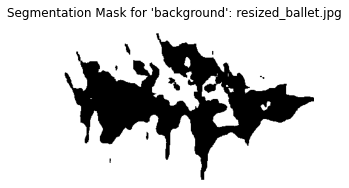

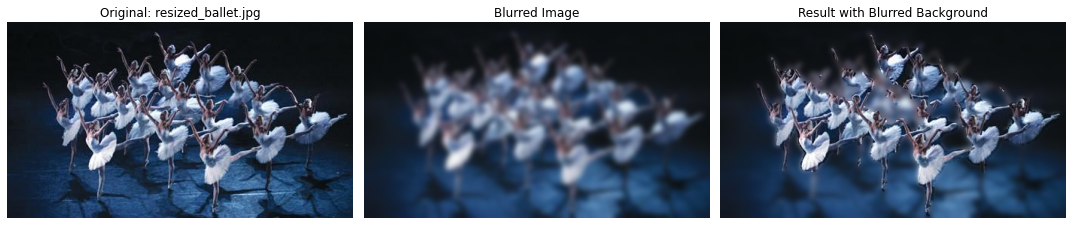

Processing resized_lake.jpg for background blurring...


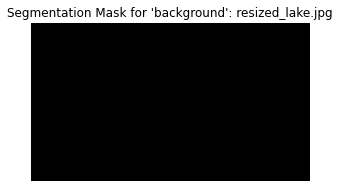

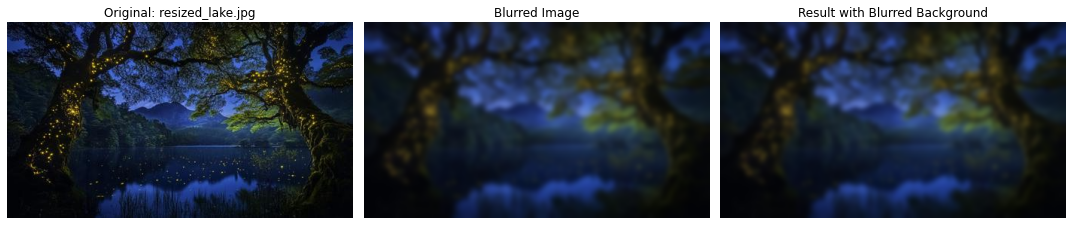

Processing resized_ltt.jpg for background blurring...


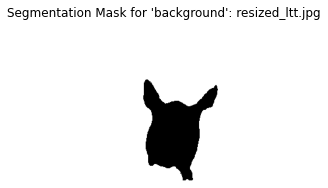

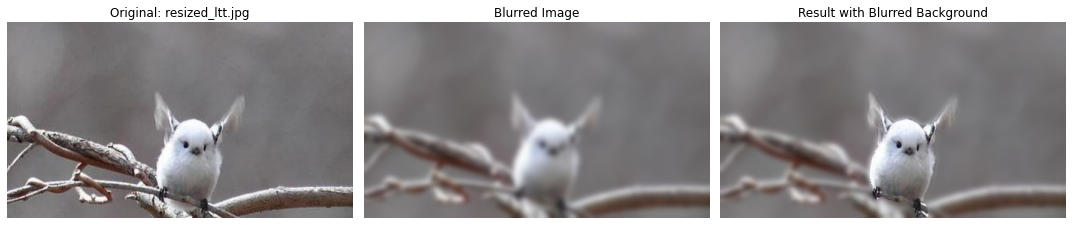

In [6]:
# Background 영역 블러 처리
for file in resized_files:
    print(f"Processing {file} for background blurring...")
    
    # 이미지 읽기
    img = cv2.imread(file)
    
    # 세그멘테이션 수행
    segvalues, output = model.segmentAsPascalvoc(file)
    
    # Background 클래스 ID (PASCAL VOC 데이터셋에서 'background'는 ID 0)
    background_class_id = 0
    
    # 세그멘테이션 마스크 생성 (background 영역만 선택)
    seg_map = np.all(output == np.array([background_class_id, background_class_id, background_class_id]), axis=-1)
    
    # 마스크 시각화 (선택된 영역 확인)
    plt.figure(figsize=(5, 5))
    plt.imshow(seg_map, cmap='gray')
    plt.title(f"Segmentation Mask for 'background': {file}")
    plt.axis('off')
    plt.show()
    
    # Background 영역 블러 처리
    img_blur = cv2.GaussianBlur(img, (21, 21), 0)  # 블러링 커널 크기 (21x21)
    
    # 마스크를 이용하여 원본 이미지와 블러 이미지 합성
    mask = seg_map.astype(np.uint8) * 255
    mask_inv = cv2.bitwise_not(mask)
    
    img_target = cv2.bitwise_and(img_blur, img_blur, mask=mask)  # 블러 처리된 영역
    img_foreground = cv2.bitwise_and(img, img, mask=mask_inv)   # 원본 전경 영역
    
    img_result = cv2.add(img_target, img_foreground)  # 두 이미지를 합성
    
    # 결과 시각화
    plt.figure(figsize=(15, 5))
    
    # 원본 이미지 표시
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original: {file}")
    plt.axis('off')
    
    # 블러 처리된 전체 이미지 표시
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB))
    plt.title("Blurred Image")
    plt.axis('off')
    
    # 최종 합성 이미지 표시
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    plt.title("Result with Blurred Background")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Processing resized_ballet.jpg for background replacement with lake...


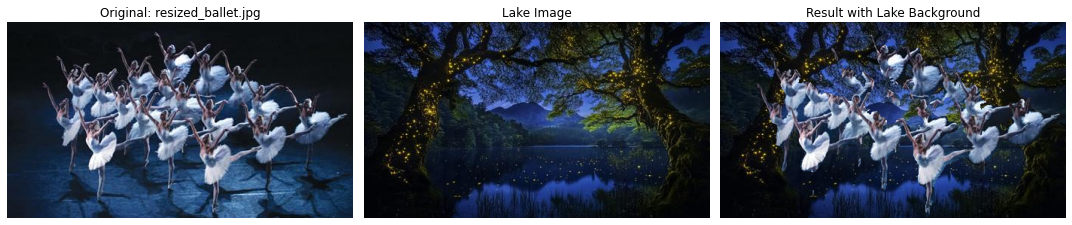

Processing resized_lake.jpg for background replacement with lake...


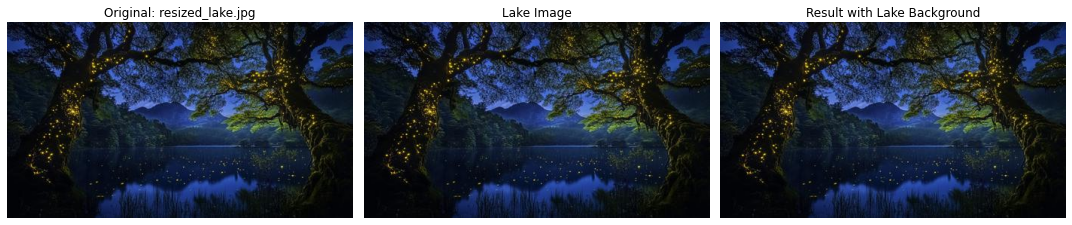

Processing resized_ltt.jpg for background replacement with lake...


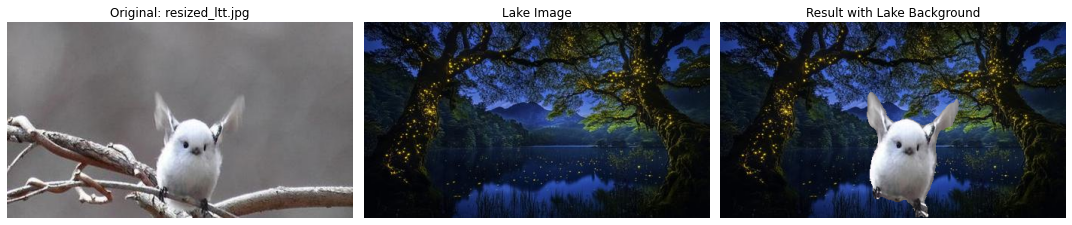

In [7]:
# Background 영역을 lake.jpg로 대체
lake_image_path = 'resized_lake.jpg'  # 합성에 사용할 이미지
lake_image = cv2.imread(lake_image_path)

for file in resized_files:
    print(f"Processing {file} for background replacement with lake...")
    
    # 이미지 읽기
    img = cv2.imread(file)
    
    # 세그멘테이션 수행
    segvalues, output = model.segmentAsPascalvoc(file)
    
    # Background 클래스 ID (PASCAL VOC 데이터셋에서 'background'는 ID 0)
    background_class_id = 0
    
    # 세그멘테이션 마스크 생성 (background 영역만 선택)
    seg_map = np.all(output == np.array([background_class_id, background_class_id, background_class_id]), axis=-1)
    
    # lake 이미지를 원본 이미지 크기로 리사이즈
    lake_resized = cv2.resize(lake_image, (img.shape[1], img.shape[0]))
    
    # 마스크를 이용하여 lake 이미지를 background 영역에 삽입
    mask = seg_map.astype(np.uint8) * 255
    mask_inv = cv2.bitwise_not(mask)
    
    img_background = cv2.bitwise_and(lake_resized, lake_resized, mask=mask)  # lake 배경 영역
    img_foreground = cv2.bitwise_and(img, img, mask=mask_inv)               # 원본 전경 영역
    
    img_result = cv2.add(img_background, img_foreground)  # 두 이미지를 합성
    
    # 결과 시각화
    plt.figure(figsize=(15, 5))
    
    # 원본 이미지 표시
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original: {file}")
    plt.axis('off')
    
    # lake 이미지 표시
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(lake_resized, cv2.COLOR_BGR2RGB))
    plt.title("Lake Image")
    plt.axis('off')
    
    # 최종 합성 이미지 표시
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
    plt.title("Result with Lake Background")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Matplotlib is building the font cache; this may take a moment.



Processing ballet.jpg...
Original size of ballet.jpg: (460, 260)
Resized size of ballet.jpg: (460, 260)


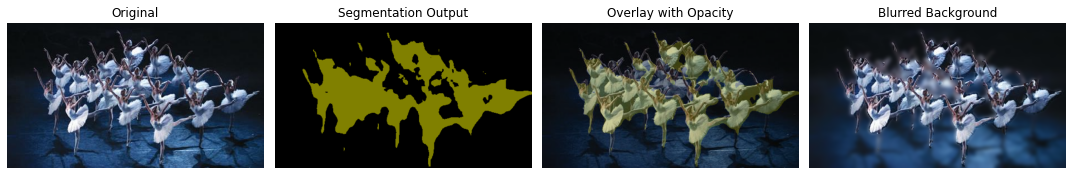


Processing lake.jpg...
Original size of lake.jpg: (1527, 850)
Resized size of lake.jpg: (460, 260)


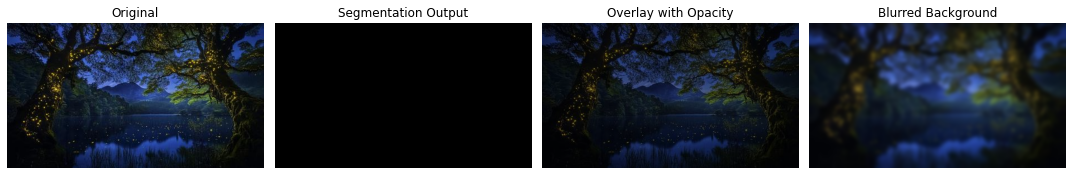


Processing ltt.jpg...
Original size of ltt.jpg: (570, 299)
Resized size of ltt.jpg: (460, 260)


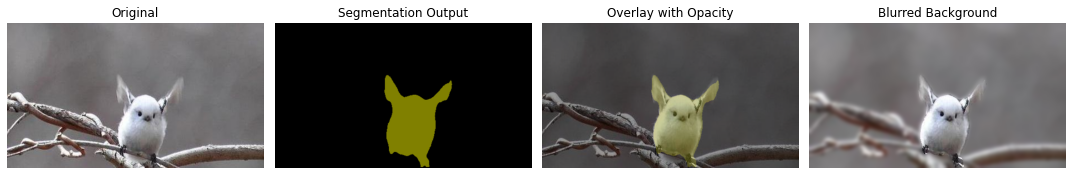

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from pixellib.semantic import semantic_segmentation
import matplotlib.pyplot as plt


# **모듈 1: 가장 작은 이미지 크기 계산**
def get_minimum_size(image_files):
    try:
        sizes = [Image.open(file).size for file in image_files]
        min_width = min(size[0] for size in sizes)
        min_height = min(size[1] for size in sizes)
        return min_width, min_height
    except Exception as e:
        print(f"Error calculating minimum size: {e}")
        return None  # 에러 발생 시 None 반환

# **모듈 2: 이미지 리사이징**
def resize_image(image_path, target_size):
    img = Image.open(image_path)
    resized_img = img.resize(target_size, Image.LANCZOS)
    return resized_img


# **모듈 3: 세그멘테이션 모델 초기화**
def initialize_segmentation_model(model_dir='./'):
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
    if not os.path.exists(model_file):
        model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
        print("Downloading model...")
        import urllib.request
        urllib.request.urlretrieve(model_url, model_file)
        print("Model downloaded!")
    
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)
    return model


# **모듈 4: 세그멘테이션 수행**
def perform_segmentation(model, image_path):
    segvalues, output = model.segmentAsPascalvoc(image_path)
    return segvalues, output


# **모듈 5: 오파시티 적용된 이미지 생성**
def apply_opacity(img, segmentation_output, opacity=0.4):
    output_resized = cv2.resize(segmentation_output, (img.shape[1], img.shape[0]))
    overlay = cv2.addWeighted(img, 1 - opacity, output_resized, opacity, 0)
    return overlay


# **모듈 6: 배경 블러 처리**
def blur_background(img, segmentation_output):
    background_class_id = 0
    seg_map = np.all(segmentation_output == np.array([background_class_id] * 3), axis=-1)
    
    img_blur = cv2.GaussianBlur(img, (21, 21), 0)
    
    mask = seg_map.astype(np.uint8) * 255
    mask_inv = cv2.bitwise_not(mask)
    
    img_target = cv2.bitwise_and(img_blur, img_blur, mask=mask)
    img_foreground = cv2.bitwise_and(img, img, mask=mask_inv)
    
    result_img = cv2.add(img_target, img_foreground)
    return result_img


# **모듈 7: 이미지 시각화**
def visualize_images(images, titles):
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, len(images), i)
        if isinstance(img, np.ndarray):  # OpenCV 이미지 처리
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:  # PIL 이미지 처리
            plt.imshow(np.array(img))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# **메인 함수**
def process_image(image_path, target_size=None, model=None):
    # 원본 이미지 로드 및 크기 확인
    original_img = Image.open(image_path)
    
    print(f"Original size of {image_path}: {original_img.size}")
    
    # 리사이징 (제일 작은 크기로 설정된 target_size 사용)
    resized_img = resize_image(image_path, target_size)
    
    print(f"Resized size of {image_path}: {resized_img.size}")
    
    # 리사이징된 이미지 저장
    resized_file_path = f"resized_{os.path.basename(image_path)}"
    resized_img.save(resized_file_path)
    
    # 세그멘테이션 수행
    if model is None:
        raise ValueError("Segmentation model is not initialized.")
    
    segvalues, segmentation_output = perform_segmentation(model, resized_file_path)

    # OpenCV로 이미지를 읽어오기 (세그멘테이션 및 블러 작업용)
    img_cv2 = cv2.imread(resized_file_path)

    # 오파시티 적용된 이미지 생성
    overlay_img = apply_opacity(img_cv2, segmentation_output)

    # 배경 블러 처리된 이미지 생성
    blurred_background_img = blur_background(img_cv2, segmentation_output)

    # 결과 시각화
    visualize_images(
        [img_cv2, segmentation_output, overlay_img, blurred_background_img],
        ["Original", "Segmentation Output", "Overlay with Opacity", "Blurred Background"]
    )


# **전체 실행**
if __name__ == "__main__":
    # 모델 초기화
    segmentation_model = initialize_segmentation_model()

    # 처리할 이미지 파일 리스트
    image_files = ['ballet.jpg', 'lake.jpg', 'ltt.jpg']

    # 제일 작은 크기 계산
    target_size = get_minimum_size(image_files)

    if target_size is None:
        print("Failed to calculate the minimum size. Please check the image files.")
    else:
        for image_file in image_files:
            print(f"\nProcessing {image_file}...")
            process_image(image_file, target_size=target_size, model=segmentation_model)


In [ ]:
# 마스크 후처리 추가
'''
세그멘테이션 출력 이미지를 그레이스케일로 변환.
**이진화(Thresholding)**를 통해 바이너리 마스크 생성.
모폴로지 연산(침식 및 팽창)을 사용하여 노이즈 제거 및 경계 보정.
컨투어 기반 홀 채우기로 객체 내부의 구멍을 채워 일관된 마스크 생성.
'''

In [2]:
# **모듈 : 마스크 후처리**
def refine_segmentation_mask(segmentation_output):
    # 세그멘테이션 출력을 그레이스케일로 변환
    gray_mask = cv2.cvtColor(segmentation_output, cv2.COLOR_BGR2GRAY)

    # 이진화(Thresholding)를 통해 바이너리 마스크 생성
    _, binary_mask = cv2.threshold(gray_mask, 1, 255, cv2.THRESH_BINARY)

    # 모폴로지 연산을 적용하여 마스크 정리
    kernel = np.ones((5, 5), np.uint8)

    # 침식(Erosion)으로 작은 노이즈 제거 후 팽창(Dilation)으로 객체 크기 복원
    cleaned_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # 마스크 내부의 구멍을 채우기
    contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    refined_mask = np.zeros_like(cleaned_mask)
    
    for contour in contours:
        cv2.drawContours(refined_mask, [contour], -1, (255), thickness=cv2.FILLED)

    # 데이터 타입을 uint8로 변환 (OpenCV 호환성 유지)
    refined_mask = refined_mask.astype(np.uint8)

    return refined_mask


In [3]:
# **수정된 메인 함수**
def process_image(image_path, target_size=None, model=None):
    # 원본 이미지 로드 및 크기 확인
    original_img = Image.open(image_path)
    
    print(f"Original size of {image_path}: {original_img.size}")
    
    # 리사이징 (제일 작은 크기로 설정된 target_size 사용)
    resized_img = resize_image(image_path, target_size)
    
    print(f"Resized size of {image_path}: {resized_img.size}")
    
    # 리사이징된 이미지 저장
    resized_file_path = f"resized_{os.path.basename(image_path)}"
    resized_img.save(resized_file_path)
    
    # 세그멘테이션 수행
    if model is None:
        raise ValueError("Segmentation model is not initialized.")
    
    segvalues, segmentation_output = perform_segmentation(model, resized_file_path)

    # OpenCV로 이미지를 읽어오기 (세그멘테이션 및 블러 작업용)
    img_cv2 = cv2.imread(resized_file_path)

    # 마스크 후처리 적용
    refined_mask = refine_segmentation_mask(segmentation_output)

    # 오파시티 적용된 이미지 생성
    overlay_img = apply_opacity(img_cv2, refined_mask)

    # 배경 블러 처리된 이미지 생성
    blurred_background_img = blur_background(img_cv2, refined_mask)

    # 결과 시각화
    visualize_images(
        [img_cv2, segmentation_output, refined_mask, overlay_img, blurred_background_img],
        ["Original", "Raw Segmentation Output", "Refined Mask", "Overlay with Opacity", "Blurred Background"]
    )


In [ ]:
'''
error: OpenCV(4.5.3) /tmp/pip-req-build-agffqapq/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'

이 에러는 apply_opacity 함수에서 OpenCV의 cv2.addWeighted를 호출할 때, 입력 이미지(img)와 세그멘테이션 마스크(segmentation_output 또는
refined_mask)의 크기나 채널 수가 일치하지 않아서 발생합니다.
'''

In [4]:
# **수정된 모듈 5: 오파시티 적용된 이미지 생성**
def apply_opacity(img, segmentation_output, opacity=0.4):
    # 세그멘테이션 마스크 크기를 원본 이미지 크기에 맞게 조정
    output_resized = cv2.resize(segmentation_output, (img.shape[1], img.shape[0]))

    # 마스크를 3채널로 변환
    if len(output_resized.shape) == 2:  # 만약 마스크가 1채널(그레이스케일)이라면
        output_resized = cv2.cvtColor(output_resized, cv2.COLOR_GRAY2BGR)

    # 오파시티 적용
    overlay = cv2.addWeighted(img, 1 - opacity, output_resized, opacity, 0)
    return overlay


In [ ]:
'''
error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'bitwise_not'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'

이 에러는 blur_background 함수에서 cv2.bitwise_not 함수에 전달된 mask가 OpenCV에서 처리할 수 없는 형식이기 때문에 발생합니다. 
이 문제는 seg_map 또는 mask가 올바른 NumPy 배열 형식이 아니거나, 데이터 타입이 OpenCV에서 처리할 수 없는 형태로 변환되었기 때문입니다.
'''

In [5]:
# **수정된 모듈 6: 배경 블러 처리**
def blur_background(img, segmentation_output):
    # Background 클래스 ID (PASCAL VOC 데이터셋에서 'background'는 ID 0)
    background_class_id = 0

    # 세그멘테이션 마스크가 그레이스케일(1채널)인지 확인
    if len(segmentation_output.shape) == 2:  # 1채널 (그레이스케일)
        seg_map = segmentation_output == background_class_id
    else:  # 다채널 (RGB)
        seg_map = np.all(segmentation_output == np.array([background_class_id] * 3), axis=-1)

    # Gaussian Blur 적용
    img_blur = cv2.GaussianBlur(img, (21, 21), 0)  # 블러링 커널 크기 (21x21)

    # 마스크 생성
    mask = (seg_map.astype(np.uint8)) * 255

    # 데이터 타입 확인 및 변환
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask, dtype=np.uint8)

    mask_inv = cv2.bitwise_not(mask)

    # 배경 블러와 전경 합성
    img_target = cv2.bitwise_and(img_blur, img_blur, mask=mask)  # 블러 처리된 영역
    img_foreground = cv2.bitwise_and(img, img, mask=mask_inv)   # 원본 전경 영역

    img_result = cv2.add(img_target, img_foreground)  # 두 이미지를 합성

    return img_result



Processing ballet.jpg...
Original size of ballet.jpg: (460, 260)
Resized size of ballet.jpg: (460, 260)


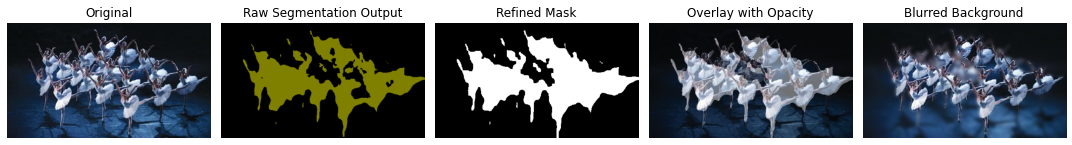


Processing lake.jpg...
Original size of lake.jpg: (1527, 850)
Resized size of lake.jpg: (460, 260)


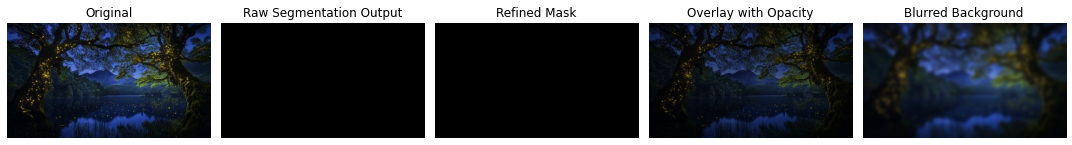


Processing ltt.jpg...
Original size of ltt.jpg: (570, 299)
Resized size of ltt.jpg: (460, 260)


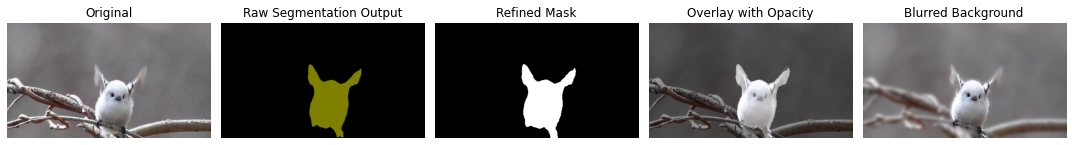

In [6]:
# **수정된 전체 실행**
if __name__ == "__main__":
    # 모델 초기화
    segmentation_model = initialize_segmentation_model()

    # 처리할 이미지 파일 리스트
    image_files = ['ballet.jpg', 'lake.jpg', 'ltt.jpg']

    # 제일 작은 크기 계산
    target_size = get_minimum_size(image_files)

    if target_size is None:
        print("Failed to calculate the minimum size. Please check the image files.")
    else:
        for image_file in image_files:
            print(f"\nProcessing {image_file}...")
            process_image(image_file, target_size=target_size, model=segmentation_model)


In [ ]:
'''
회고

가상환경 이라 pip install 해도 버전이 변하지 않는 등의 문제로 다른 모델을 사용함에 에러사항이 있었다.


'''